In [1]:
import torch
from torch import nn, optim

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm


%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" # я запускал в google colab и почему-то были проблемы с cuda, я решил пока не думать об этом

In [3]:
mu1 = torch.tensor([10., 3.], device=device, dtype=torch.float32)
mu2 = torch.tensor([6., -1.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

p = 0.8
N = 10000

batch_size = 100
num_epoches = 250
z_dim = 2

In [4]:
c = torch.distributions.Bernoulli(p). sample((N, )).to(device).view(-1, 1)
a = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N, ))
b = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N, ))

In [5]:
X = torch.tensor([[0, 0] for i in range(N)], device=device, dtype=torch.float32)
# X[:, 0] = c * a[:, 0] + (1 - c) * b[:, 0]
# X[:, 1] = c * a[:, 1] + (1 - c) * b[:, 1]

X = c * a + (1 - c) * b

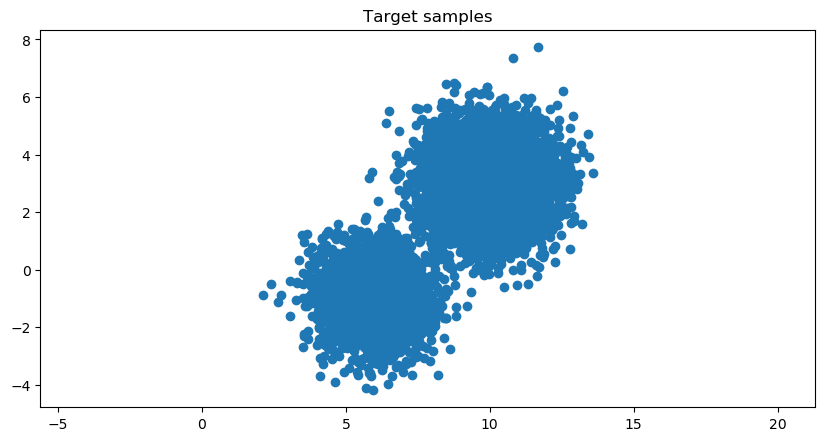

In [6]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu());

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(2, 10)
        self.fc1 = nn.Linear(10, z_dim) # for encoder
        self.fc2 = nn.Linear(10, z_dim)

        
        self.fc3 = nn.Linear(z_dim, 10)
        self.fc4 = nn.Linear(10, 2) # for decoder

    def encode(self, x):
        h = torch.relu(self.fc0(x))
        return self.fc1(h), self.fc2(h) # mu and logvar -- pframeters of q_{phi}
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
  
    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return self.fc4(h) # mu_0 -- parameter of p_{theta}

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar 

In [8]:
model = VAE().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

In [9]:
def loss_function(x, mu_0, mu, logvar):
    KL = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()) # KL-divergence
    distr = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
    ELH = distr.log_prob(x) # 1-MC approximation of expected log likelihood
    return KL.mean() - ELH.mean()

In [10]:
dataloader = DataLoader(X, batch_size=batch_size, shuffle=True, )

In [11]:
for epoch in tqdm(range(num_epoches)):
    for batch in dataloader:
        mu_0, mu, logvar = model(batch)
        loss = loss_function(batch, mu_0, mu, logvar)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % 50 == 0:
        print(loss.cpu().detach().numpy())

  0%|          | 1/250 [00:00<01:41,  2.44it/s]

41.24319


 20%|██        | 51/250 [00:20<01:19,  2.50it/s]

2.7392218


 40%|████      | 101/250 [00:40<00:59,  2.50it/s]

2.6455128


 60%|██████    | 151/250 [01:00<00:40,  2.47it/s]

2.6117988


 80%|████████  | 201/250 [01:20<00:19,  2.51it/s]

2.6691318


100%|██████████| 250/250 [01:40<00:00,  2.50it/s]


In [12]:
# for i in range(len(X)):
#     input = X[i]
#     optimizer.zero_grad()
#     mu_0, mu, logvar = model(input)
#     loss = loss_function(input, mu_0, mu, logvar)
#     loss.backward()
#     optimizer.step()

In [13]:
prior = torch.distributions.normal.Normal(torch.tensor(0., device=device, dtype=torch.float32),
                                          torch.tensor(1., device=device, dtype=torch.float32),)

In [14]:
pr_samples = prior.sample((1000, z_dim))
# pr_samples = torch.tensor([[pr_samples[i]] for i in range(1000)])

In [15]:
mu_0 = model.decode(pr_samples).detach().cpu()

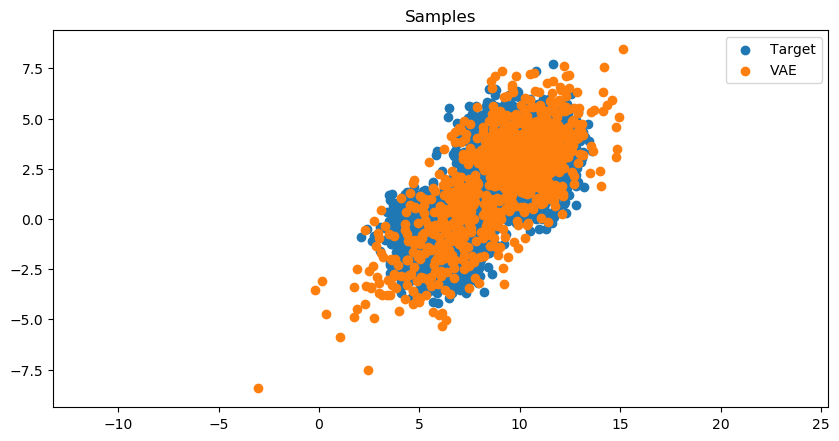

In [16]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], label='Target')
plt.scatter(mu_0[:, 0], mu_0[:, 1], label='VAE')
plt.axis('equal')
plt.legend();

### План:
0. Покрутить параметры (добавить слои, увеличить z_dim и тд), чтобы получить хорошие картинки.
1. Каждый объект пришел из какой то гауссианы, мы можем это отследить. Х или из 0, или из 1
2. Запомнить индексы, откуда объект пришел
3. Взять большой батч исходных объектов, и прогнать через энкодер. z_dim=2 (или 1)
4. Раскрасить в разные цвета объекты, в соответс. с тем, из какого пика пришли.
5. Интуция: получится "граница", по разные стороны от которой лежат разные кластеры
6. Попробовать MoG prior: возьмем смесь двух гауссиан, с обучаемыми mu и std.


#### Метрики:
1. Просто на глаз (оба, и восстановленные объекты, и латентное представление)
2. Likelihood.

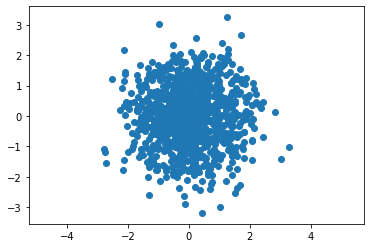

In [17]:
s = torch.randn((1000, 2))
plt.scatter(s[:, 0], s[:, 1])
plt.axis('equal');